Linux archiso 5.10.26-1-lts x86_64 GNU/Linux 

mariadb  Ver 15.1 Distrib 10.5.9-MariaDB, for Linux (x86_64) using readline 5.1

In [120]:
import os
import csv
import MySQLdb
import numpy as np
import pandas as pd
import seaborn as sn
from datetime import datetime
from dotenv import load_dotenv
load_dotenv()

passwd = os.getenv('PASSWD')
mydb = MySQLdb.connect(host='localhost',
                       user='root',
                       passwd=passwd,
                       db='orders')
cursor = mydb.cursor()

csv_data = 'orders_20190822.csv'
i = 0
with open(csv_data, newline='') as csvfile:
    columns = csvfile.readline().replace('"', '`').split(';')
    columns = ', '.join(columns)
    reader = csv.reader(csvfile, delimiter=';')
    
    for row in reader:     
        id_o, user_id, price = row[0], row[1], int(row[2].replace(',', ''))
        date = datetime.strptime(row[3].replace('.', '-'), '%d-%m-%Y').date()
        table_name = csv_data[:csv_data.index('.')]
        cursor.execute(f'INSERT INTO {table_name}({columns}) VALUES("%s", "%s", "%s", "%s");' % (id_o, user_id, price, date, ))
        if not i % 100000:
            print(f'{i} records - done')
        i += 1
print("Done")
%time

0 records - done
100000 records - done
200000 records - done
300000 records - done
400000 records - done
500000 records - done
600000 records - done
700000 records - done
800000 records - done
900000 records - done
1000000 records - done
1100000 records - done
1200000 records - done
1300000 records - done
1400000 records - done
1500000 records - done
1600000 records - done
1700000 records - done
1800000 records - done
1900000 records - done
2000000 records - done
Done
CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10 µs


In [121]:
average_orders = pd.read_sql_query('''SELECT `year`, `month`, AVG(`cnt`) `average` 
                        FROM (SELECT YEAR(`o_date`) as `year`, MONTH(`o_date`) `month`, 
                            COUNT(`user_id`) `cnt` FROM `orders_20190822` GROUP BY `user_id`) 
                            as t GROUP BY `month`, `year` ORDER BY `year`, `month`;''', mydb)
average_check = pd.read_sql_query('''SELECT YEAR(`o_date`) `year`, MONTH(`o_date`) `month`, AVG(`price`) `average` 
                                    FROM `orders_20190822` GROUP BY `month`, `year`;''', mydb)
%time

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 9.06 µs


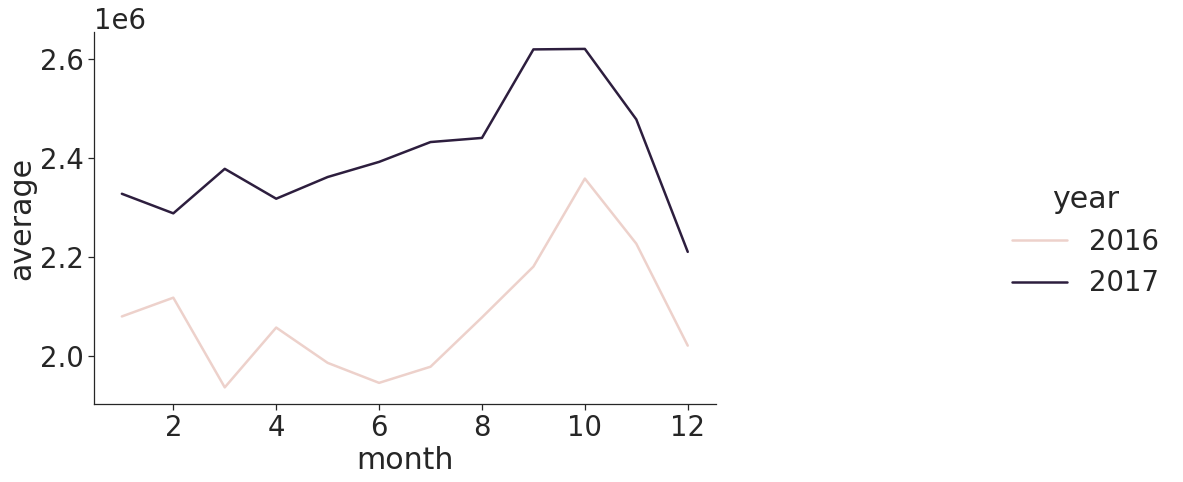

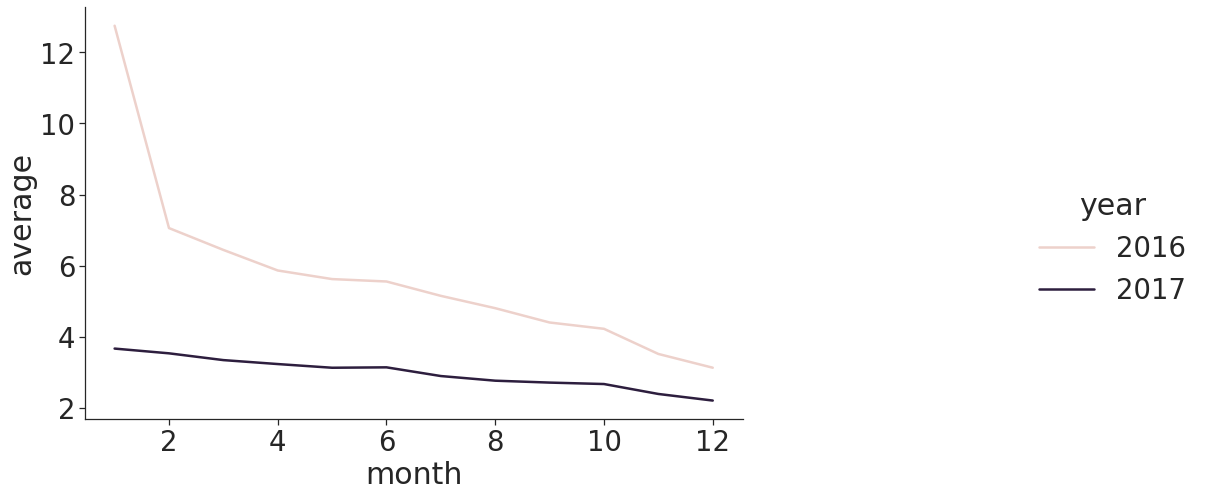

In [129]:
def get_relplot(tbl):
    month = tbl['month']
    avg = tbl['average']
    g = sns.relplot(x=month, y=avg, hue="year", data=tbl, kind="line");
    g.fig.set_size_inches(20,8);
    sns.set_style("ticks");
    sns.color_palette("tab10");
    sns.set_context("notebook", font_scale=2.5, rc={"lines.linewidth": 2.5});
get_relplot(average_check)
get_relplot(average_orders)